In [96]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.multivariate.manova import MANOVA


In [36]:
build_ener_df = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

display(
    set(
        build_ener_df.loc[build_ener_df["PrimaryPropertyType"] == "Residence Hall"][
            "BuildingType"
        ].to_list()
    )
)
with pd.option_context("display.max_columns", None):
    display(
        build_ener_df.loc[
            (build_ener_df["PrimaryPropertyType"] == "Residence Hall")
            & (build_ener_df["BuildingType"] == "NonResidential")
        ]
    )
display(
    set(
        build_ener_df.loc[
            build_ener_df["LargestPropertyUseType"] == "Prison/Incarceration"
        ]["BuildingType"].to_list()
    )
)


{'Multifamily MR (5-9)', 'NonResidential'}

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
115,183,2016,NonResidential,Residence Hall,Emerson Hall,500 W. Emerson,Seattle,WA,98119.0,7443000375,7,MAGNOLIA / QUEEN ANNE,47.65068,-122.36331,2001,1.0,4,139600,37500,102100,Residence Hall/Dormitory,Residence Hall/Dormitory,135520.0,NaN,NaN,NaN,NaN,NaN,89.0,32.799999,35.400002,70.199997,74.699997,4.448582e+06,4.800620e+06,0.00,6.788682e+05,2316298.0,21322.839840,2132284.0,False,NaN,Compliant,NaN,129.39,0.93
186,294,2016,NonResidential,Residence Hall,Women's Residence at Seneca,1118 5th Avenue,Seattle,WA,98101.0,2301950000,7,DOWNTOWN,47.60790,-122.33266,1913,1.0,9,107572,0,107572,"Office, Residence Hall/Dormitory, Retail Store",Residence Hall/Dormitory,63934.0,Office,27143.0,Retail Store,10568.0,NaN,76.0,54.799999,57.799999,113.500000,117.099998,5.572503e+06,5.879083e+06,3076446.50,7.315522e+05,2496056.0,0.000000,0.0,False,NaN,Compliant,NaN,254.87,2.37
858,20029,2016,NonResidential,Residence Hall,Washington Phikeia Foundation,2111 NE 47th St,Seattle,WA,98105.0,0925049089,4,NORTHEAST,47.66282,-122.30500,1921,1.0,3,21499,0,21499,Residence Hall/Dormitory,Residence Hall/Dormitory,21499.0,NaN,NaN,NaN,NaN,NaN,85.0,28.100000,28.100000,88.400002,88.400002,6.051307e+05,6.051307e+05,0.00,1.773536e+05,605130.0,0.000000,0.0,False,NaN,Compliant,NaN,4.22,0.20
890,20160,2016,NonResidential,Residence Hall,Sigma Kappa Corp,4510 22nd Ave NE,Seattle,WA,98105.0,1321300090,4,NORTHEAST,47.66159,-122.30441,1930,1.0,3,20960,0,20960,Residence Hall/Dormitory,Residence Hall/Dormitory,20960.0,NaN,NaN,NaN,NaN,NaN,NaN,71.599998,79.500000,107.900002,117.599998,1.500310e+06,1.667310e+06,0.00,9.636570e+04,328800.0,11715.099610,1171510.0,False,NaN,Compliant,NaN,64.51,3.08
934,20273,2016,NonResidential,Residence Hall,Brooklyn Plaza,4106 Brooklyn Ave Ne,Seattle,WA,98105.0,1142001455,4,NORTHEAST,47.65711,-122.31409,1993,1.0,3,28572,0,28572,"Parking, Residence Hall/Dormitory",Residence Hall/Dormitory,22000.0,Parking,7000.0,NaN,NaN,NaN,16.0,123.500000,125.400002,242.500000,244.500000,2.717863e+06,2.759012e+06,0.00,3.479411e+05,1187175.0,15306.879880,1530688.0,False,NaN,Compliant,NaN,89.57,3.13
952,20323,2016,NonResidential,Residence Hall,Chancery Place Apartments,910 Marion Street,Seattle,WA,98104.0,1510600000,3,EAST,47.60817,-122.32654,1982,0.0,15,115775,31535,84240,"Office, Residence Hall/Dormitory",Residence Hall/Dormitory,150000.0,Office,25000.0,NaN,NaN,NaN,94.0,16.500000,17.400000,51.700001,54.599998,2.882490e+06,3.042217e+06,0.00,8.448093e+05,2882489.0,0.000000,0.0,False,NaN,Compliant,NaN,20.09,0.17
1104,20861,2016,NonResidential,Residence Hall,(ID20861) KEYSTONE GROUP HOME,3515 WOODLAND PARK AVE N,Seattle,WA,98103.0,1825049055,4,LAKE UNION,47.65014,-122.34424,1988,1.0,3,21118,0,21118,Residence Hall/Dormitory,Residence Hall/Dormitory,21118.0,NaN,NaN,NaN,NaN,NaN,49.0,64.500000,67.599998,138.100006,145.500000,1.361428e+06,1.427645e+06,0.00,2.083642e+05,710939.0,6504.889648,650489.0,False,NaN,Compliant,NaN,39.50,1.87
1210,21262,2016,NonResidential,Residence Hall,(ID21262) El Rey Apts,2119 2ND AVE,Seattle,WA,98121.0,1977200720,7,DOWNTOWN,47.61283,-122.34392,1909,1.0,4,29796,0,29796,Residence Hall/Dormitory,Residence Hall/Dormitory,29796.0,NaN,NaN,NaN,NaN,NaN,47.0,75.0000

{'Nonresidential COS'}

In [37]:
build_ener_df = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

print(build_ener_df.shape[0])

build_ener_df = build_ener_df.loc[
    (
        ~build_ener_df["BuildingType"].isin(
            ["Multifamily HR (10+)", "Multifamily LR (1-4)", "Multifamily MR (5-9)"]
        )
    )
    & (
        ~build_ener_df["PrimaryPropertyType"].isin(
            [
                "High-Rise Multifamily",
                "Low-Rise Multifamily",
                "Mid-Rise Multifamily",
                "Residence Hall",
                # "Senior Care Community",
            ]
        )
    )
    & (
        ~build_ener_df["LargestPropertyUseType"].isin(
            [
                "Multifamily Housing",
                "Other - Lodging/Residential",
                "Residence Hall/Dormitory",
                # "Residential Care Facility",
                # "Senior Care Community",
            ]
        )
    )
]

build_ener_df.reset_index(drop=True, inplace=True)
print(build_ener_df.shape[0])


3376
1629


In [38]:
build_ener_df.describe()


,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,1629.000000,1629.0,1613.000000,1629.000000,1629.000000,1629.000000,1629.000000,1627.000000,1629.000000,1.629000e+03,...,1.627000e+03,1.626000e+03,1.627000e+03,1.627000e+03,1.627000e+03,1.627000e+03,1.627000e+03,0.0,1627.000000,1627.000000
mean,16106.317986,2016.0,98116.699318,4.353591,47.615659,-122.333159,1961.905463,1.171481,4.108042,1.195486e+05,...,8.546335e+06,8.159922e+06,5.217879e+05,1.735611e+06,5.921906e+06,1.988956e+04,1.988956e+06,NaN,187.193159,1.610621
std,13777.032930,0.0,17.999159,2.202625,0.048462,0.024682,32.525830,2.964442,6.572922,2.997562e+05,...,3.058713e+07,2.227995e+07,5.578664e+06,6.163686e+06,2.103050e+07,9.478920e+04,9.478920e+06,NaN,760.638229,2.358555
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.411820,1900.000000,0.000000,0.000000,1.128500e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,577.000000,2016.0,98105.000000,2.000000,47.584540,-122.343400,1930.000000,1.000000,1.000000,2.961900e+04,...,1.222025e+06,1.287964e+06,0.000000e+00,2.118562e+05,7.228535e+05,0.000000e+00,0.000000e+00,NaN,19.840000,0.340000
50%,21117.000000,2016.0,98109.000000,4.000000,47.612200,-122.333050,1965.000000,1.000000,2.000000,4.976000e+04,...,2.559462e+06,2.691883e+06,0.000000e+00,4.744772e+05,1.618916e+06,4.910900e+03,4.910900e+05,NaN,49.290000,0.870000
75%,24560.000000,2016.0,98125.000000,7.000000,47.649040,-122.321930,1989.000000,1.000000,4.000000,1.060000e+05,...,6.979178e+06,7.239068e+06,0.000000e+00,1.436401e+06,4.901002e+06,1.517566e+04,1.517566e+06,NaN,144.600000,1.875000
max,50226.000000,2016.0,98199.000000,7.000000,47.733870,-122.258640,2015.000000,111.000000,99.000000,9.320156e+06,...,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


In [39]:
for col in build_ener_df.columns:
    if (
        len(set(build_ener_df[col].to_list())) == 1
        or len(build_ener_df[col].loc[~build_ener_df[col].isna()].to_list()) == 0
    ):
        build_ener_df = build_ener_df.drop(labels=col, axis=1)

with pd.option_context("display.max_columns", None):
    display(build_ener_df)


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,Compliant,NaN,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,Compliant,NaN,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,Compliant,NaN,2089.28,2.19
3,5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,Compliant,NaN,286.43,4.67
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,50222,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,Error - Correct Default Data,NaN,20.94,1.70
1625,50223,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,Compliant,NaN,32.17,2.01
1626,50224,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,Compliant,NaN,223.54,16.99
1627,50225,Nonresident

In [40]:
discontin_feats = [
    "BuildingType",
    "PrimaryPropertyType",
    "PropertyName",
    "Address",
    "ZipCode",
    "TaxParcelIdentificationNumber",
    "CouncilDistrictCode",
    "Neighborhood",
    "Latitude",
    "Longitude",
    "YearBuilt",
    "ListOfAllPropertyUseTypes",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
    "DefaultData",
    "ComplianceStatus",
    "Outlier",
]
discontin_broad_feats = [
    "BuildingType",
    "PrimaryPropertyType",
    "ZipCode",
    "CouncilDistrictCode",
    "Neighborhood",
    "YearBuilt",
    "ListOfAllPropertyUseTypes",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
    "DefaultData",
    "ComplianceStatus",
    "Outlier",
]
unique_vals = {}

for feat in discontin_broad_feats:
    unique_vals[feat] = sorted([f"{i}" for i in set(build_ener_df[feat].to_numpy())])

display(unique_vals)


{'BuildingType': ['Campus',
  'NonResidential',
  'Nonresidential COS',
  'Nonresidential WA',
  'SPS-District K-12'],
 'PrimaryPropertyType': ['Distribution Center',
  'Hospital',
  'Hotel',
  'K-12 School',
  'Laboratory',
  'Large Office',
  'Medical Office',
  'Mixed Use Property',
  'Office',
  'Other',
  'Refrigerated Warehouse',
  'Restaurant',
  'Retail Store',
  'Self-Storage Facility',
  'Senior Care Community',
  'Small- and Mid-Sized Office',
  'Supermarket / Grocery Store',
  'University',
  'Warehouse',
  'Worship Facility'],
 'ZipCode': ['98006.0',
  '98011.0',
  '98013.0',
  '98020.0',
  '98033.0',
  '98053.0',
  '98070.0',
  '98101.0',
  '98102.0',
  '98103.0',
  '98104.0',
  '98105.0',
  '98106.0',
  '98107.0',
  '98108.0',
  '98109.0',
  '98111.0',
  '98112.0',
  '98113.0',
  '98114.0',
  '98115.0',
  '98116.0',
  '98117.0',
  '98118.0',
  '98119.0',
  '98121.0',
  '98122.0',
  '98124.0',
  '98125.0',
  '98126.0',
  '98133.0',
  '98134.0',
  '98136.0',
  '98144.0',
 

In [41]:
display(sorted(set(build_ener_df["Neighborhood"].to_list())))
build_ener_df["Neighborhood"] = build_ener_df["Neighborhood"].apply(lambda x: x.upper())
display(sorted(set(build_ener_df["Neighborhood"].to_list())))


['BALLARD',
 'Ballard',
 'CENTRAL',
 'Central',
 'DELRIDGE',
 'DELRIDGE NEIGHBORHOODS',
 'DOWNTOWN',
 'Delridge',
 'EAST',
 'GREATER DUWAMISH',
 'LAKE UNION',
 'MAGNOLIA / QUEEN ANNE',
 'NORTH',
 'NORTHEAST',
 'NORTHWEST',
 'North',
 'Northwest',
 'SOUTHEAST',
 'SOUTHWEST']

['BALLARD',
 'CENTRAL',
 'DELRIDGE',
 'DELRIDGE NEIGHBORHOODS',
 'DOWNTOWN',
 'EAST',
 'GREATER DUWAMISH',
 'LAKE UNION',
 'MAGNOLIA / QUEEN ANNE',
 'NORTH',
 'NORTHEAST',
 'NORTHWEST',
 'SOUTHEAST',
 'SOUTHWEST']

In [42]:
addresses = build_ener_df["Address"].to_list()
addr_cnts = {}

for addr in addresses:
    if addresses.count(addr) > 1:
        if addr not in addr_cnts:
            addr_cnts[addr] = addresses.count(addr)

for addr in addr_cnts.keys():
    lats_longs = []
    addr_df = build_ener_df.loc[build_ener_df["Address"] == addr]
    lats = addr_df["Latitude"].to_list()
    longs = addr_df["Longitude"].to_list()

    for i in range(len(lats)):
        lats_longs += [[lats[i], longs[i]]]

    lats_longs = list(set(tuple(sorted(sub)) for sub in lats_longs))
    addr_cnts[addr] = lats_longs

display(addr_cnts)

for addr in addr_cnts.keys():
    if len(addr_cnts[addr]) > 1:
        with pd.option_context("display.max_columns", None):
            display(build_ener_df.loc[build_ener_df["Address"] == addr])


{'500 5TH AVE': [(-122.32927, 47.6029), (-122.32842, 47.60378)],
 '2600 SW Barton St': [(-122.36627, 47.52254)],
 '3613 4th Ave S': [(-122.32811, 47.57199)],
 '1100 Olive Way': [(-122.33086, 47.61597)],
 '100 West Harrison': [(-122.3585, 47.62224)],
 '2203 Airport Way S': [(-122.32417, 47.5829)],
 '309 South Cloverdale Street': [(-122.33064, 47.52549)],
 '201 Thomas St.': [(-122.35251, 47.62082)],
 '2400 11th Ave East': [(-122.31644, 47.64132)],
 '14050 1st Ave NE': [(-122.32784, 47.73143)],
 '10510 5th Ave NE': [(-122.32232, 47.70541)],
 '4636 East Marginal Way South': [(-122.33872, 47.56121)],
 '2600 SW Holden St': [(-122.36624, 47.53419)],
 '2309 S Jackson St': [(-122.30189, 47.59881)]}

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
20,27,NonResidential,Other,King County Correctional Facility,500 5TH AVE,98104.0,0942001010,3,DOWNTOWN,47.60378,-122.32842,1985,1.0,19,385274,0,385274,Other,Other,385274.0,NaN,NaN,NaN,NaN,NaN,NaN,124.199997,128.600006,229.500000,232.899994,47859812.0,49539212.0,0.0,5351014.50,18257661.0,296021.5,29602150.0,False,Compliant,NaN,1699.45,4.41
568,779,NonResidential,Large Office,Administration Building,500 5TH AVE,98104.0,0942000920,7,DOWNTOWN,47.60290,-122.32927,1971,1.0,9,224857,0,224857,Office,Office,204993.0,NaN,NaN,NaN,NaN,NaN,79.0,74.500000,78.800003,195.699997,200.899994,15272491.0,16162013.0,4047481.0,3289861.75,11225008.0,0.0,0.0,False,Compliant,NaN,390.67,1.74


In [43]:
prop_use_types = build_ener_df["ListOfAllPropertyUseTypes"].to_list()
for i in range(len(prop_use_types)):
    prop_use_types[i] = str(prop_use_types[i]).split(", ")
    if prop_use_types[i] != sorted(prop_use_types[i]):
        print(prop_use_types[i])


['Other - Mall', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)']
['Repair Services (Vehicle', 'Shoe', 'Locksmith', 'etc)']
['Convenience Store without Gas Station', 'Data Center', 'Financial Office', 'Fitness Center/Health Club/Gym', 'Office', 'Other', 'Parking', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)', 'Restaurant']
['Office', 'Parking', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)']
['Fitness Center/Health Club/Gym', 'Office', 'Other - Education', 'Other - Recreation', 'Other - Restaurant/Bar', 'Outpatient Rehabilitation/Physical Therapy', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)', 'Restaurant', 'Retail Store', 'Self-Storage Facility', 'Vocat']
['Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)', 'Retail Store', 'Supermarket/Grocery Store']
['Bar/Nightclub', 'Office', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)']
['Data Center', 'Non-Refrigerated Warehouse', 'Other', 'Refrigerated Warehouse', 'Repair S

In [44]:
print(build_ener_df.shape[0])

build_ener_df_def_dat = build_ener_df.loc[build_ener_df["DefaultData"]]
build_ener_df_comp_err = build_ener_df.loc[
    build_ener_df["ComplianceStatus"] == "Error - Correct Default Data"
]

if build_ener_df_def_dat.compare(build_ener_df_comp_err).shape[0] == 0:
    build_ener_df = build_ener_df.loc[
        ~(build_ener_df["ComplianceStatus"] == "Error - Correct Default Data")
    ]

    build_ener_df.reset_index(drop=True, inplace=True)

print(build_ener_df.shape[0])


1629
1541


In [45]:
display(
    pd.DataFrame(
        {
            "SiteEnergyUse(kBtu)": build_ener_df["SiteEnergyUse(kBtu)"],
            "SiteEnergyUse(kBtu)Reconst": build_ener_df["PropertyGFATotal"]
            * build_ener_df["SiteEUI(kBtu/sf)"],
        }
    ).head(20)
)
display(
    pd.DataFrame(
        {
            "SiteEnergyUse(kBtu)": build_ener_df["SiteEnergyUse(kBtu)"],
            "SiteEnergyUse(kBtu)Reconst": build_ener_df["PropertyGFABuilding(s)"]
            * build_ener_df["SiteEUI(kBtu/sf)"],
        }
    ).head(20)
)


,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)Reconst
0,7226362.5,7.225058e+06
1,8387933.0,9.818057e+06
2,72587024.0,9.178656e+07
3,6794584.0,6.794256e+06
4,14172606.0,2.015658e+07
5,12086616.0,1.324090e+07
6,5758795.0,5.876967e+06
7,6298131.5,6.299249e+06
8,13723820.0,1.372546e+07
9,16016644.0,1.831829e+07


,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)Reconst
0,7226362.5,7.225058e+06
1,8387933.0,8.389990e+06
2,72587024.0,7.290163e+07
3,6794584.0,6.794256e+06
4,14172606.0,1.303898e+07
5,12086616.0,8.178249e+06
6,5758795.0,5.876967e+06
7,6298131.5,6.299249e+06
8,13723820.0,1.372546e+07
9,16016644.0,1.601253e+07


In [46]:
gfa_df = pd.DataFrame(
    {
        "PropertyGFATotal": build_ener_df["PropertyGFATotal"],
        "PropertyGFATotalReconst": build_ener_df["PropertyGFAParking"]
        + build_ener_df["PropertyGFABuilding(s)"],
    }
)
abber_gfas = []

for index, row in gfa_df.iterrows():
    gfa_abs_diff = abs(row["PropertyGFATotal"] - row["PropertyGFATotalReconst"])
    if gfa_abs_diff > 0:
        abber_gfas += [gfa_abs_diff]

print(abber_gfas)


[]


In [47]:
print(build_ener_df.shape[0])

build_ener_df = build_ener_df.loc[
    ~(
        (build_ener_df["SiteEnergyUse(kBtu)"] <= 0)
        | np.isnan(build_ener_df["SiteEnergyUse(kBtu)"])
        | (build_ener_df["TotalGHGEmissions"] <= 0)
        | np.isnan(build_ener_df["TotalGHGEmissions"])
    )
]

build_ener_df.reset_index(drop=True, inplace=True)
print(build_ener_df.shape[0])


1541
1522


In [48]:
eui_from_prop_idxs = []
eui_from_bldgs_idxs = []
eui_from_prkng_idxs = []
eui_disparate_idxs = []
ener = "SiteEnergyUse(kBtu)"
eui = "SiteEUI(kBtu/sf)"
gfa_prop = "PropertyGFATotal"
gfa_bldg = "PropertyGFABuilding(s)"
gfa_prk = "PropertyGFAParking"

for index, row in build_ener_df.iterrows():
    abs_diff_ener_prop = abs(row[gfa_prop] * row[eui] - row[ener])
    abs_diff_ener_bldg = abs(row[gfa_bldg] * row[eui] - row[ener])
    abs_diff_ener_prkng = abs(row[gfa_prk] * row[eui] - row[ener])

    if abs_diff_ener_prop < abs_diff_ener_bldg:
        if abs_diff_ener_prkng < abs_diff_ener_prop:
            if abs_diff_ener_prkng / row[ener] >= 0.01:
                eui_disparate_idxs += [index]
                continue
            eui_from_prkng_idxs += [index]
        else:
            if abs_diff_ener_prop / row[ener] >= 0.01:
                eui_disparate_idxs += [index]
                continue
            eui_from_prop_idxs += [index]
    elif abs_diff_ener_prkng < abs_diff_ener_bldg:
        if abs_diff_ener_prkng / row[ener] >= 0.01:
            eui_disparate_idxs += [index]
            continue
        eui_from_prkng_idxs += [index]
    else:
        if abs_diff_ener_bldg / row[ener] >= 0.01:
            eui_disparate_idxs += [index]
            continue
        eui_from_bldgs_idxs += [index]

print(
    f"EUI from proprty GFA: {len(eui_from_prop_idxs)}\n"
    + f"EUI from building GFA: {len(eui_from_bldgs_idxs)}\n"
    + f"EUI from parking GFA: {len(eui_from_prkng_idxs)}\n"
    + f"EUI without corresponding GFA: {len(eui_disparate_idxs)}\n"
)


EUI from proprty GFA: 43
EUI from building GFA: 803
EUI from parking GFA: 0
EUI without corresponding GFA: 676



In [49]:
build_ener_df.insert(
    loc=build_ener_df.columns.get_loc("SiteEnergyUseWN(kBtu)") + 1,
    column="SourceEnergyUseWN(kBtu)",
    value=np.nan,
)


In [50]:
for index, row in build_ener_df.iterrows():
    source_eui = 0

    if (
        not np.isnan(row["SourceEUIWN(kBtu/sf)"])
        and not row["SourceEUIWN(kBtu/sf)"] == 0
    ):
        source_eui = row["SourceEUIWN(kBtu/sf)"]
    else:
        source_eui = row["SourceEUI(kBtu/sf)"]

    if index in eui_from_prop_idxs:
        build_ener_df.loc[index, "SourceEnergyUseWN(kBtu)"] = source_eui * row[gfa_prop]
    elif index in eui_from_bldgs_idxs:
        build_ener_df.loc[index, "SourceEnergyUseWN(kBtu)"] = source_eui * row[gfa_bldg]
    elif index in eui_from_prkng_idxs:
        build_ener_df.loc[index, "SourceEnergyUseWN(kBtu)"] = source_eui * row[gfa_prk]
    else:
        build_ener_df.loc[index, "SourceEnergyUseWN(kBtu)"] = source_eui * row[gfa_prop]

with pd.option_context("display.max_columns", None):
    display(build_ener_df)


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,1.671403e+07,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,Compliant,NaN,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,1.587726e+07,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,Compliant,NaN,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,1.853676e+08,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,Compliant,NaN,2089.28,2.19
3,5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,1.373568e+07,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,Compliant,NaN,286.43,4.67
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,3.785505e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,50221,Nonresidential COS,Other,High Point Community Center,6920 34th Ave SW,NaN,2524039059,1,DELRIDGE NEIGHBORHOODS,47.54067,-122.37441,1982,1.0,1,18261,0,18261,Other - Recreation,Other - Recreation,18261.0,NaN,NaN,NaN,NaN,NaN,NaN,51.000000,56.200001,126.000000,136.600006,9.320821e+05,1.025432e+06,2.494453e+06,0.00,1.853347e+05,6.323620e+05,2997.199951,2.997200e+05,False,Compliant,NaN,20.33,1.11
1518,50223,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,1.902400e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,Compliant,NaN,32.17,2.01
1519,50224,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.200012,460.100006,744.799988,767.799988,5.7

In [51]:
print(build_ener_df.shape[0])

build_ener_df = build_ener_df.loc[build_ener_df["Outlier"].isna()]

build_ener_df.reset_index(drop=True, inplace=True)
print(build_ener_df.shape[0])


1522
1508


In [52]:
redund_feats = [
    "PropertyName",
    "Address",
    "TaxParcelIdentificationNumber",
    "Electricity(kWh)",
    "NaturalGas(therms)",
    "DefaultData",
]
compos_feats = [
    "YearsENERGYSTARCertified",
    "SiteEUI(kBtu/sf)",
    "SiteEUIWN(kBtu/sf)",
    "SourceEUI(kBtu/sf)",
    "SourceEUIWN(kBtu/sf)",
]
unord_categs = ["ListOfAllPropertyUseTypes"]
irrelev_feats = ["SiteEnergyUse(kBtu)", "Outlier"]

build_ener_df = build_ener_df.drop(
    redund_feats + compos_feats + unord_categs + irrelev_feats, axis=1
)

with pd.option_context("display.max_columns", None):
    display(build_ener_df)


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SourceEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,7.456910e+06,1.671403e+07,2003882.00,3.946027e+06,1.276453e+06,Compliant,249.98,2.83
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8.664479e+06,1.587726e+07,0.00,3.242851e+06,5.145082e+06,Compliant,295.86,2.86
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,756493.0,NaN,NaN,NaN,NaN,43.0,7.393711e+07,1.853676e+08,21566554.00,4.952666e+07,1.493800e+06,Compliant,2089.28,2.19
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,61320.0,NaN,NaN,NaN,NaN,56.0,6.946800e+06,1.373568e+07,2214446.25,2.768924e+06,1.811213e+06,Compliant,286.43,4.67
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,1.465650e+07,3.785505e+07,0.00,5.368607e+06,8.803998e+06,Compliant,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,50221,Nonresidential COS,Other,NaN,1,DELRIDGE NEIGHBORHOODS,47.54067,-122.37441,1982,1.0,1,18261,0,18261,Other - Recreation,18261.0,NaN,NaN,NaN,NaN,NaN,1.025432e+06,2.494453e+06,0.00,6.323620e+05,2.997200e+05,Compliant,20.33,1.11
1504,50223,Nonresidential COS,Other,NaN,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,1.053706e+06,1.902400e+06,0.00,3.965461e+05,5.537300e+05,Compliant,32.17,2.01
1505,50224,Nonresidential COS,Other,NaN,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,6.053764e+06,1.010194e+07,0.00,1.792159e+06,3.973739e+06,Compliant,223.54,16.99
1506,50225,Nonresidential COS,Mixed Use Property,NaN,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,7.828413e+05,1.562391e+06,0.00,3.488702e+05,3.706010e+05,Compliant,22.11,1.57


In [53]:
#knn
"ZipCode"
"CouncilDistrictCode"
"Latitude"
"Longitude"

"YearBuilt"
"NumberofBuildings"
"NumberofFloors"
"PropertyGFATotal"
"PropertyGFAParking"
"PropertyGFABuilding(s)"
"LargestPropertyUseTypeGFA"
"SecondLargestPropertyUseTypeGFA"
"ThirdLargestPropertyUseTypeGFA"

"ENERGYSTARScore"

"SiteEnergyUseWN(kBtu)"
"SourceEnergyUseWN(kBtu)"
"SteamUse(kBtu)"
"Electricity(kBtu)"
"NaturalGas(kBtu)"
"TotalGHGEmissions"

'TotalGHGEmissions'

In [54]:
train_locat_df = build_ener_df.loc[~build_ener_df["ZipCode"].isna()]
X = train_locat_df[["Latitude", "Longitude"]].to_numpy()
y = train_locat_df["ZipCode"].to_numpy()
error = []

for k in range(1, int(math.floor(train_locat_df.shape[0] * 4 / 5))):
    knn = KNeighborsRegressor(n_neighbors=k)
    targ_pred = cross_val_predict(knn, X, y)
    error.append(math.sqrt(mean_squared_error(y, targ_pred)))

knn_zip = KNeighborsRegressor(n_neighbors=(error.index(min(error)) + 1))

knn_zip.fit(X, y)

missing_zip_df = build_ener_df.loc[build_ener_df["ZipCode"].isna()]
missing_zips = np.around(
    knn_zip.predict(missing_zip_df[["Latitude", "Longitude"]].to_numpy())
)
missing_zip_val_idx = 0

for index, row in missing_zip_df.iterrows():
    build_ener_df.loc[index, "ZipCode"] = missing_zips[missing_zip_val_idx]
    missing_zip_val_idx += 1


In [55]:
print(build_ener_df.shape[0])

build_ener_df = build_ener_df.dropna(
    subset=[
        "LargestPropertyUseType",
        "LargestPropertyUseTypeGFA",
        "SiteEnergyUseWN(kBtu)",
    ]
)

print(build_ener_df.shape[0])


1508
1503


In [56]:
build_ener_df[
    ["SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]
] = build_ener_df[
    ["SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]
].fillna(
    value=0
)
build_ener_df[
    ["SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
] = build_ener_df[
    ["SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
].fillna(
    value=""
)

build_ener_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503 entries, 0 to 1507
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1503 non-null   int64  
 1   BuildingType                     1503 non-null   object 
 2   PrimaryPropertyType              1503 non-null   object 
 3   ZipCode                          1503 non-null   float64
 4   CouncilDistrictCode              1503 non-null   int64  
 5   Neighborhood                     1503 non-null   object 
 6   Latitude                         1503 non-null   float64
 7   Longitude                        1503 non-null   float64
 8   YearBuilt                        1503 non-null   int64  
 9   NumberofBuildings                1503 non-null   float64
 10  NumberofFloors                   1503 non-null   int64  
 11  PropertyGFATotal                 1503 non-null   int64  
 12  PropertyGFAParking  

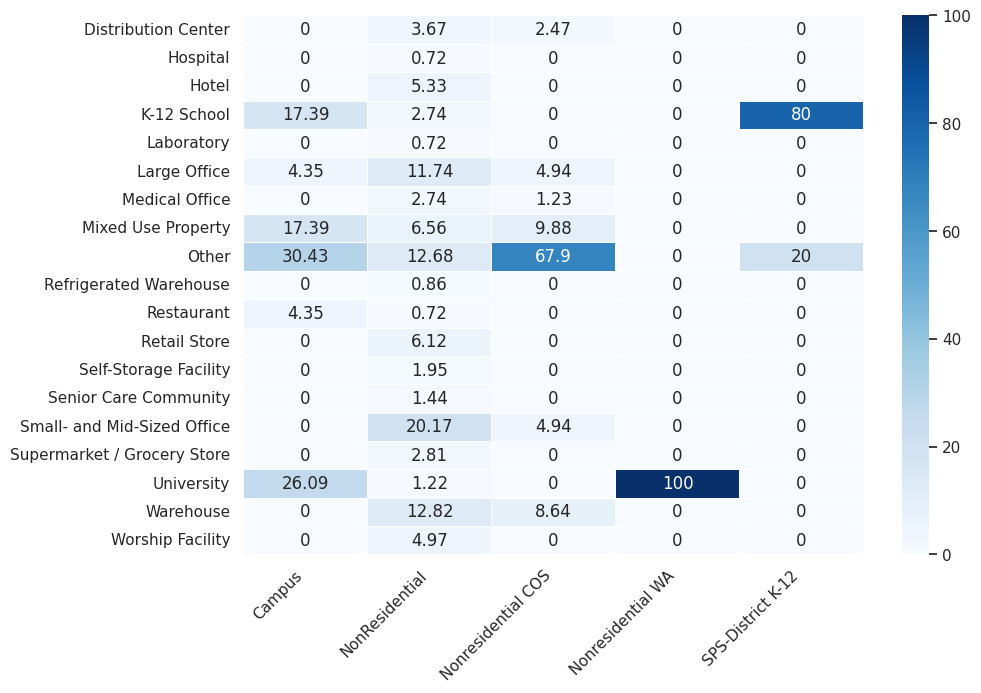

In [57]:
build_types = sorted([f"{i}" for i in set(build_ener_df["BuildingType"].to_numpy())])
prop_types = sorted(
    [f"{i}" for i in set(build_ener_df["PrimaryPropertyType"].to_numpy())]
)
build_and_prop = {}

for build_type in build_types:
    prop_type_vals = {}
    build_type_total = prop_type_total = len(
        build_ener_df[build_ener_df["BuildingType"] == build_type]
    )

    for prop_type in prop_types:
        prop_type_vals[prop_type] = round(
            100
            * (
                len(
                    build_ener_df[
                        (build_ener_df["PrimaryPropertyType"] == prop_type)
                        & (build_ener_df["BuildingType"] == build_type)
                    ]
                )
                / build_type_total
            ),
            2,
        )

    build_and_prop[build_type] = prop_type_vals

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(
    data=pd.DataFrame(build_and_prop),
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot=True,
    fmt="g",
    linewidths=0.5,
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()


In [58]:
build_ener_df_w_intens = build_ener_df
ener_cols_intens = [
    ["SiteEnergyUseWN(kBtu)", "SiteEnergyUseIntensityWN(kBtu)"],
    ["SourceEnergyUseWN(kBtu)", "SourceEnergyUseIntensityWN(kBtu)"],
    ["SteamUse(kBtu)", "SteamUseIntensity(kBtu)"],
    ["Electricity(kBtu)", "ElectricityUseIntensity(kBtu)"],
    ["NaturalGas(kBtu)", "NaturalGasUseIntensity(kBtu)"],
]

for cols in ener_cols_intens:
    build_ener_df_w_intens.insert(
        build_ener_df_w_intens.columns.get_loc(cols[0]) + 1,
        cols[1],
        build_ener_df_w_intens[cols[0]] / build_ener_df_w_intens["PropertyGFATotal"],
    )

with pd.option_context("display.max_columns", None):
    display(build_ener_df_w_intens)


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SiteEnergyUseIntensityWN(kBtu),SourceEnergyUseWN(kBtu),SourceEnergyUseIntensityWN(kBtu),SteamUse(kBtu),SteamUseIntensity(kBtu),Electricity(kBtu),ElectricityUseIntensity(kBtu),NaturalGas(kBtu),NaturalGasUseIntensity(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,,0.0,,0.0,60.0,7.456910e+06,84.321754,1.671403e+07,189.000000,2003882.00,22.659633,3.946027e+06,44.621152,1.276453e+06,14.433962,Compliant,249.98,2.83
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8.664479e+06,83.661424,1.587726e+07,153.305701,0.00,0.000000,3.242851e+06,31.311927,5.145082e+06,49.679258,Compliant,295.86,2.86
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,756493.0,,0.0,,0.0,43.0,7.393711e+07,77.331177,1.853676e+08,193.876847,21566554.00,22.556561,4.952666e+07,51.800174,1.493800e+06,1.562373,Compliant,2089.28,2.19
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,61320.0,,0.0,,0.0,56.0,6.946800e+06,113.287679,1.373568e+07,224.000000,2214446.25,36.112953,2.768924e+06,45.155316,1.811213e+06,29.537068,Compliant,286.43,4.67
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,1.465650e+07,83.474786,3.785505e+07,215.600006,0.00,0.000000,5.368607e+06,30.576415,8.803998e+06,50.142374,Compliant,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,50221,Nonresidential COS,Other,98121.0,1,DELRIDGE NEIGHBORHOODS,47.54067,-122.37441,1982,1.0,1,18261,0,18261,Other - Recreation,18261.0,,0.0,,0.0,NaN,1.025432e+06,56.154215,2.494453e+06,136.600006,0.00,0.000000,6.323620e+05,34.629101,2.997200e+05,16.413121,Compliant,20.33,1.11
1504,50223,Nonresidential COS,Other,98116.0,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,16000.0,,0.0,,0.0,NaN,1.053706e+06,65.856609,1.902400e+06,118.900002,0.00,0.000000,3.965461e+05,24.784128,5.537300e+05,34.608124,Compliant,32.17,2.01
1505,50224,Nonresidential COS,Other,98116.0,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,6.053764e+06,460.117390,1.010194e+07,767.799988,0.00,0.000000,1.792159e+06,136.213328,3.973739e+06,302.024706,Compliant,223.54,16.99
1506,50225,Nonresidential COS,Mixed Use Property,98108.0,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,7.828413e+05,55.516723,1.562391e+06,110.800003,0.00,0.000000,3.488702e+05,24.740811,3.706010e+05,26.281895,Compliant,22.11,1.57


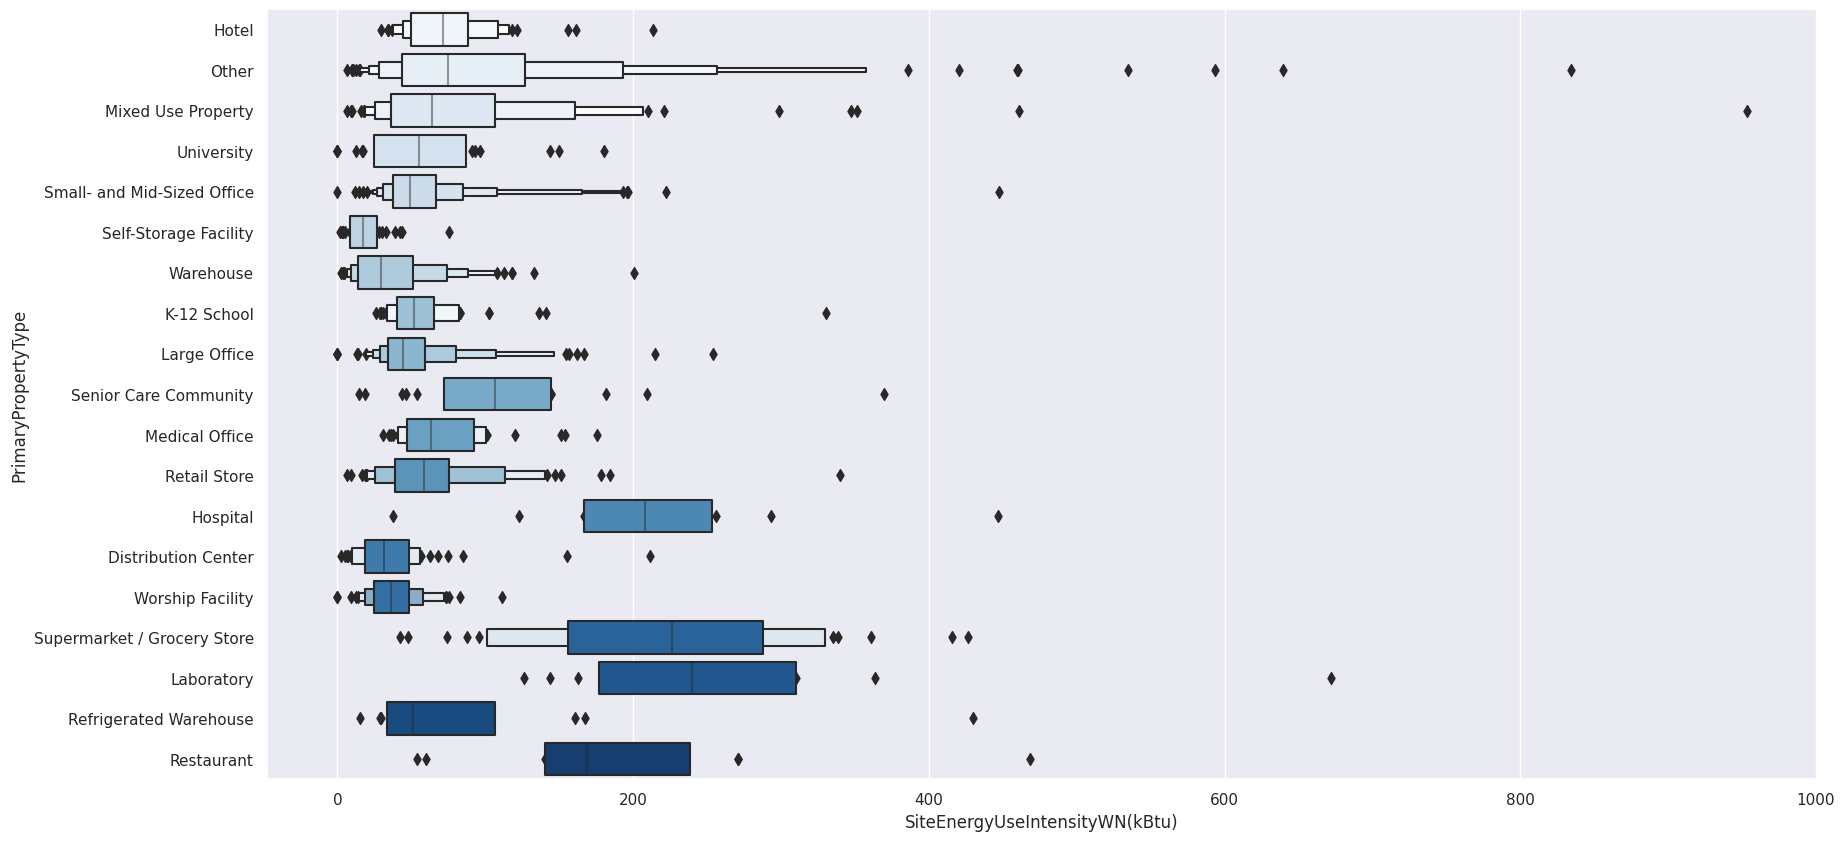

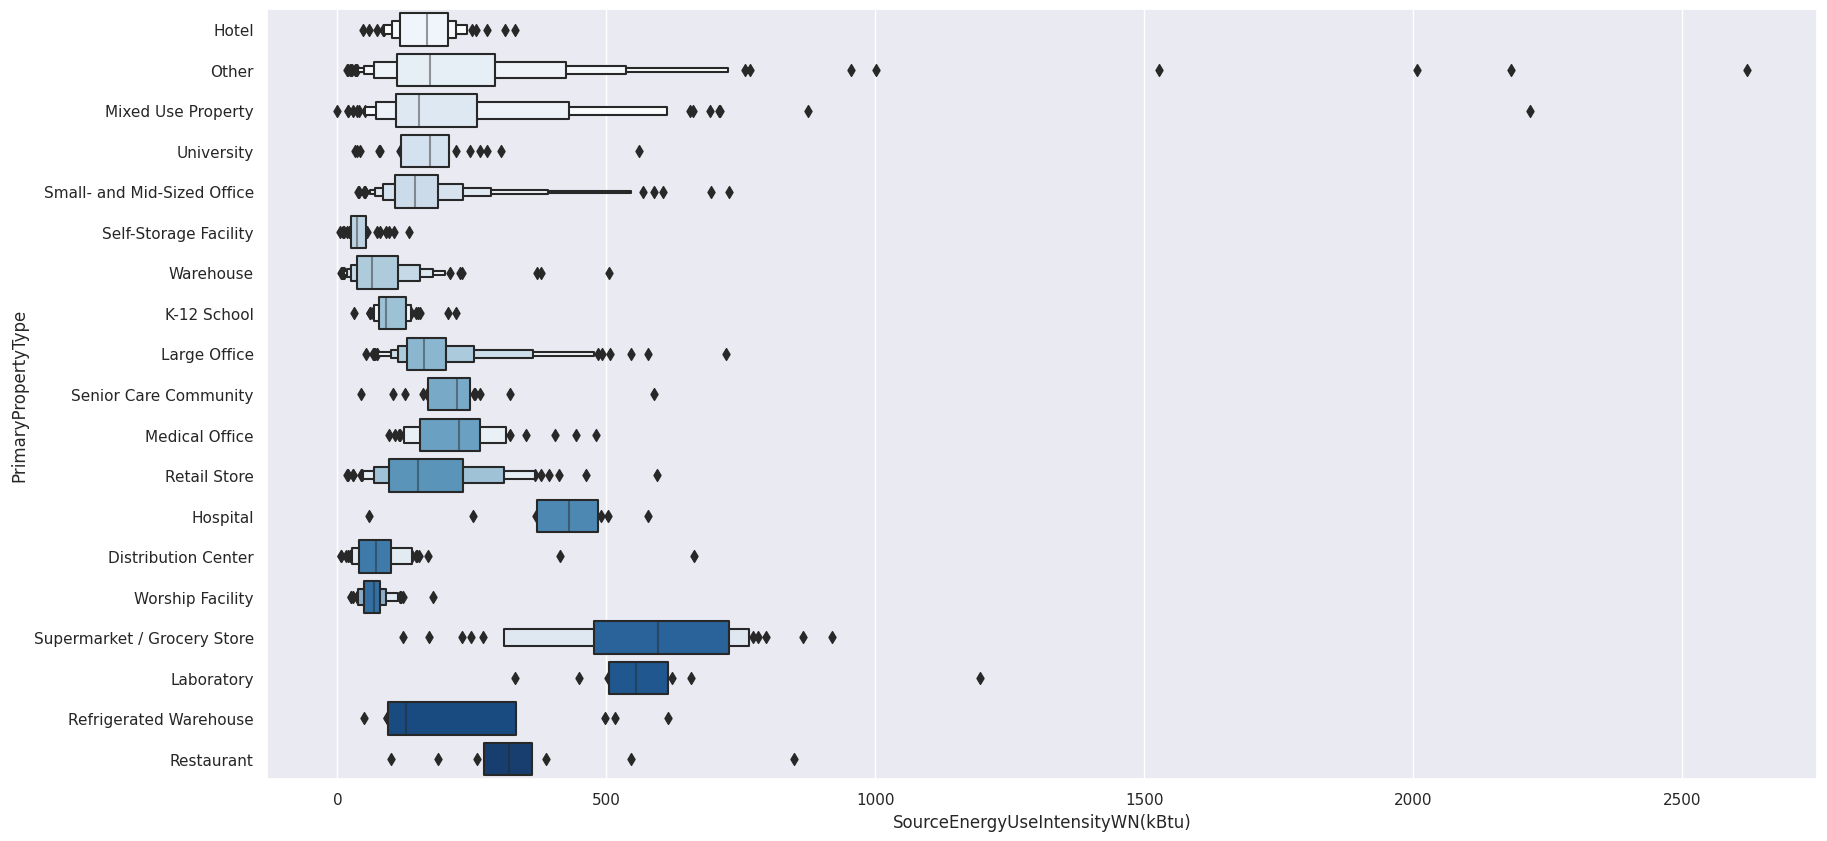

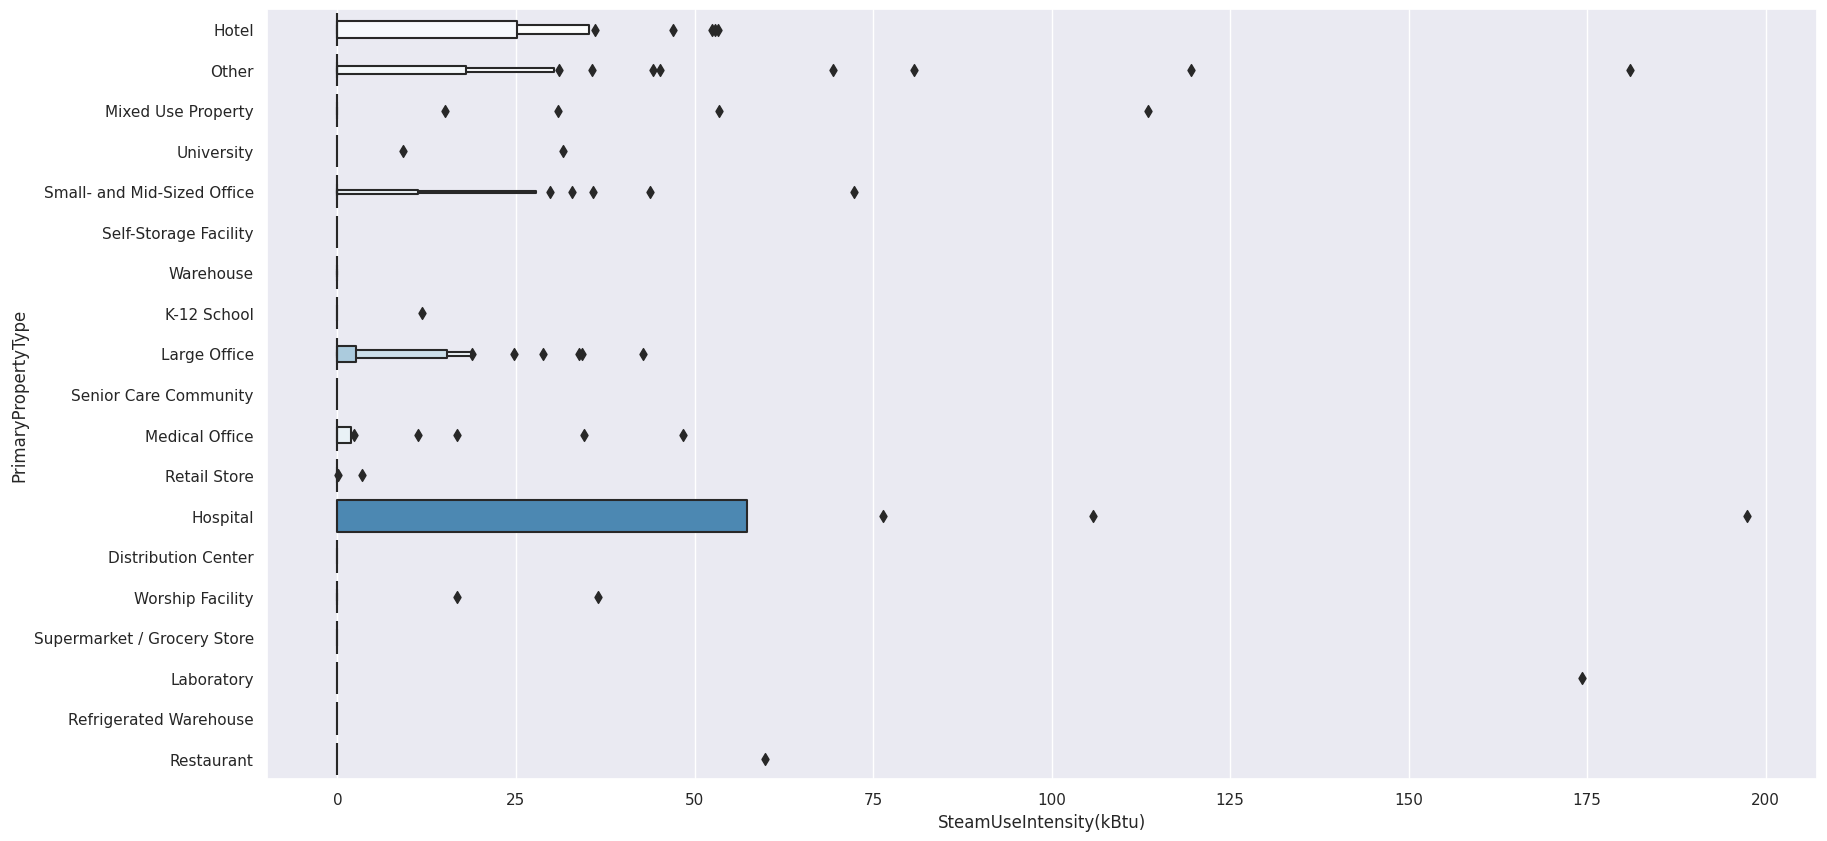

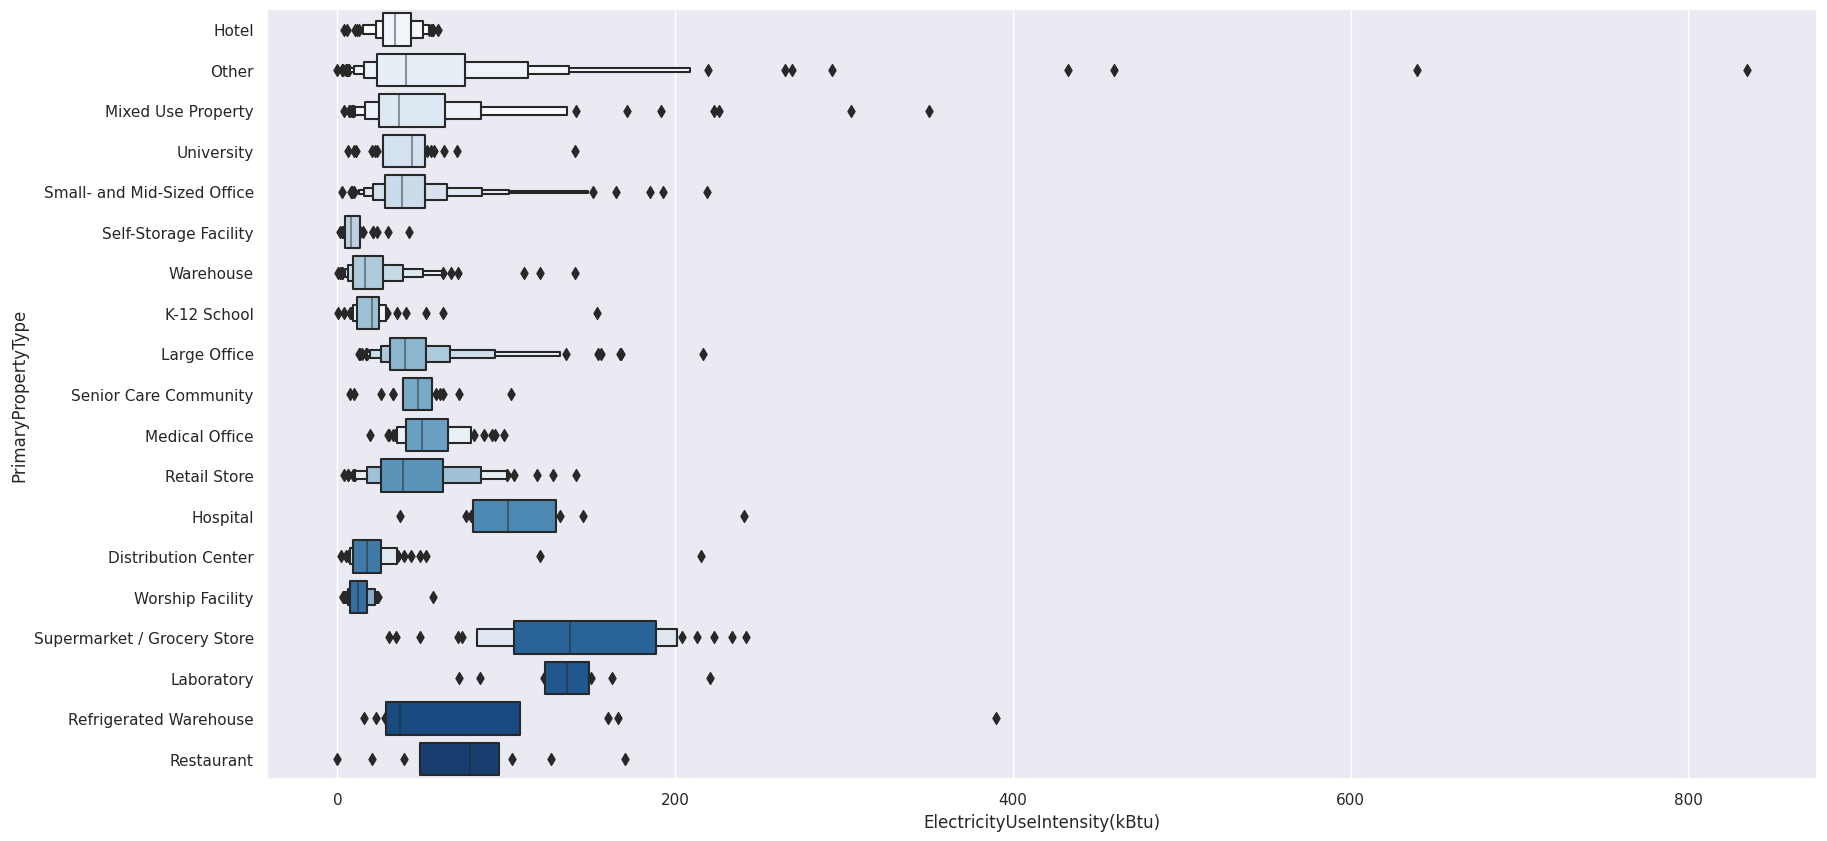

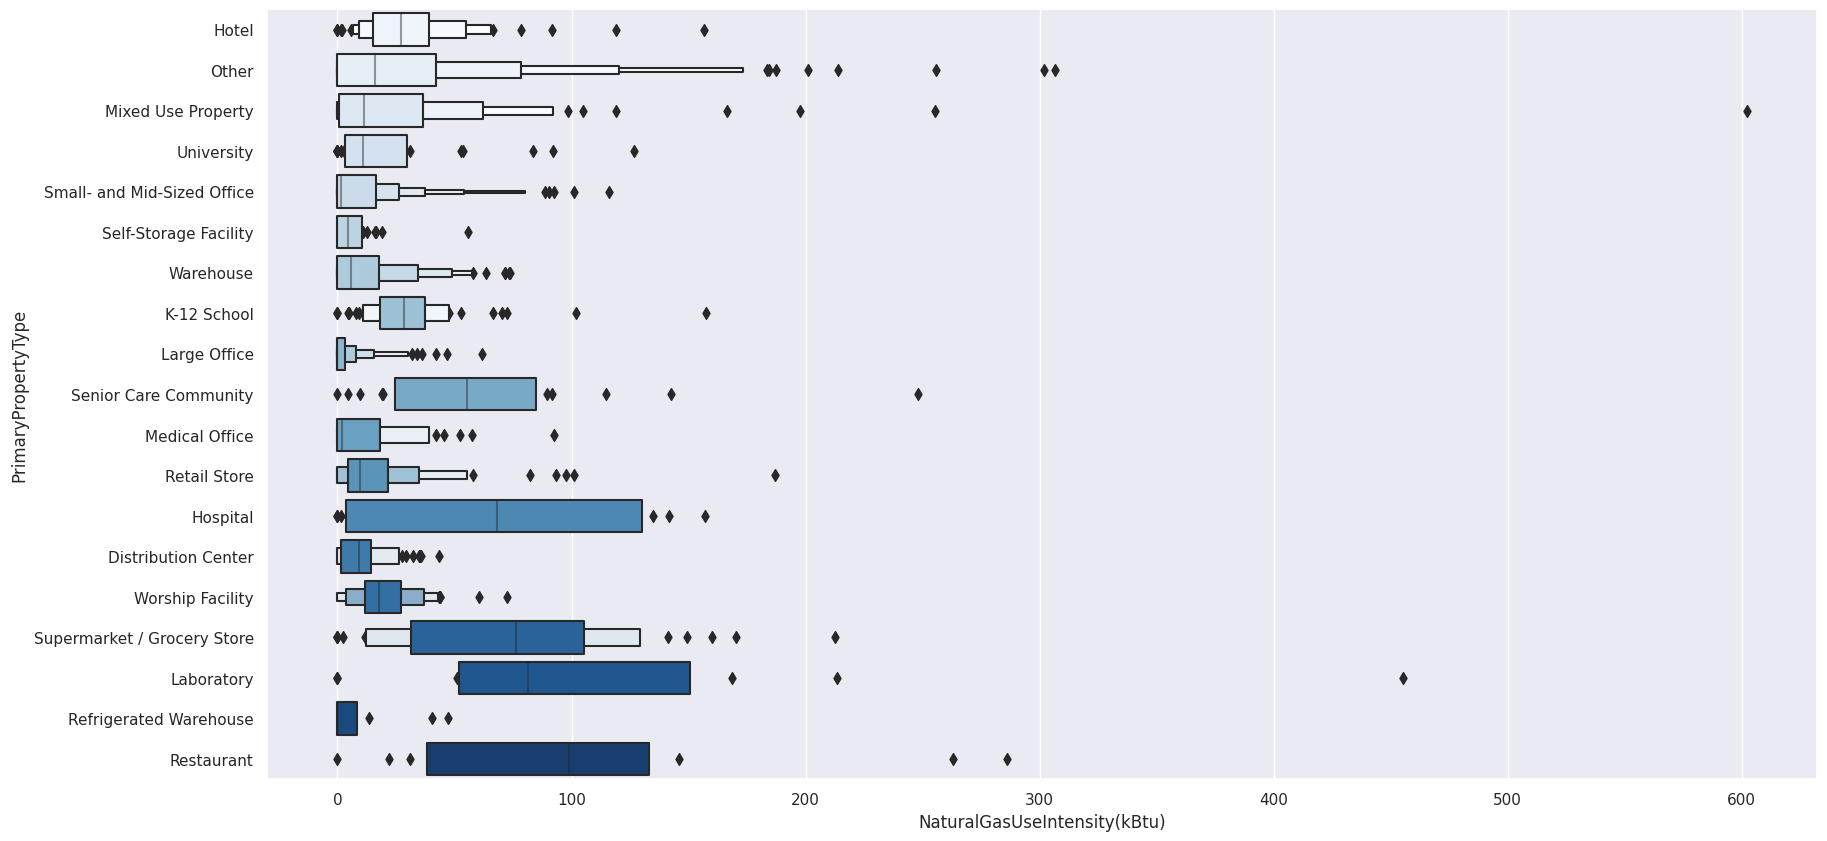

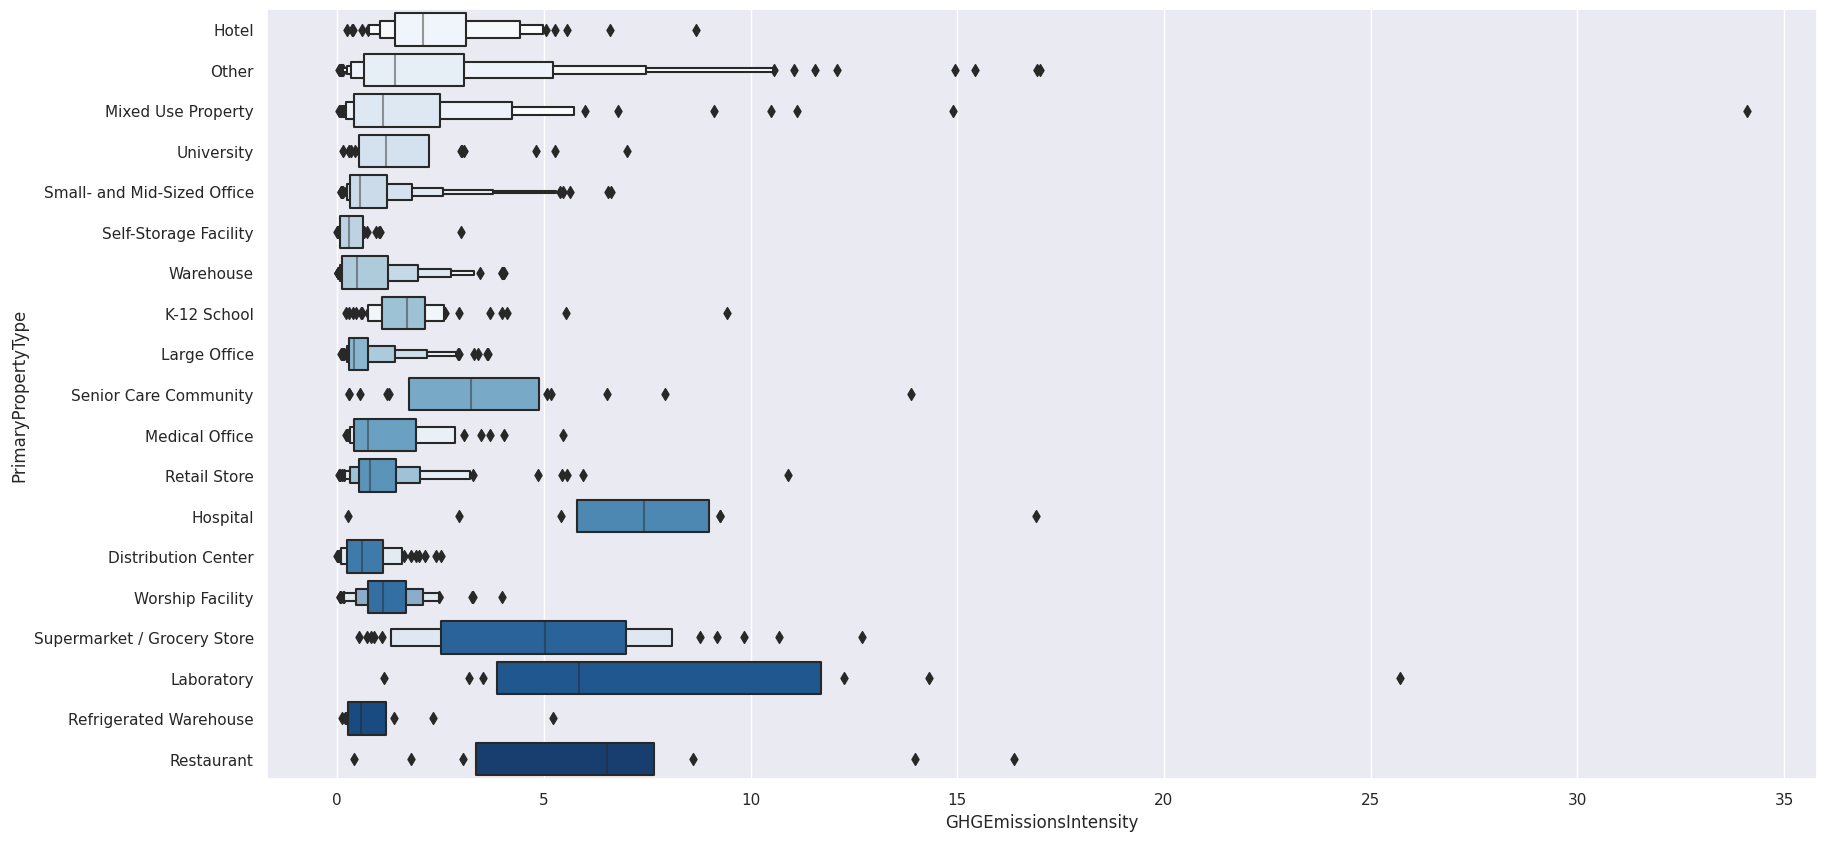

In [108]:
ener_feature_list = [
    "SiteEnergyUseIntensityWN(kBtu)",
    "SourceEnergyUseIntensityWN(kBtu)",
    "SteamUseIntensity(kBtu)",
    "ElectricityUseIntensity(kBtu)",
    "NaturalGasUseIntensity(kBtu)",
    "GHGEmissionsIntensity",
]

sns.set_theme(style="darkgrid")

for ener_feat in ener_feature_list:
    sns.boxenplot(
        y=build_ener_df_w_intens["PrimaryPropertyType"],
        x=build_ener_df_w_intens[ener_feat],
        palette="Blues",
    )
    sns.set(rc={"figure.figsize": (20, 10)})
    plt.show()


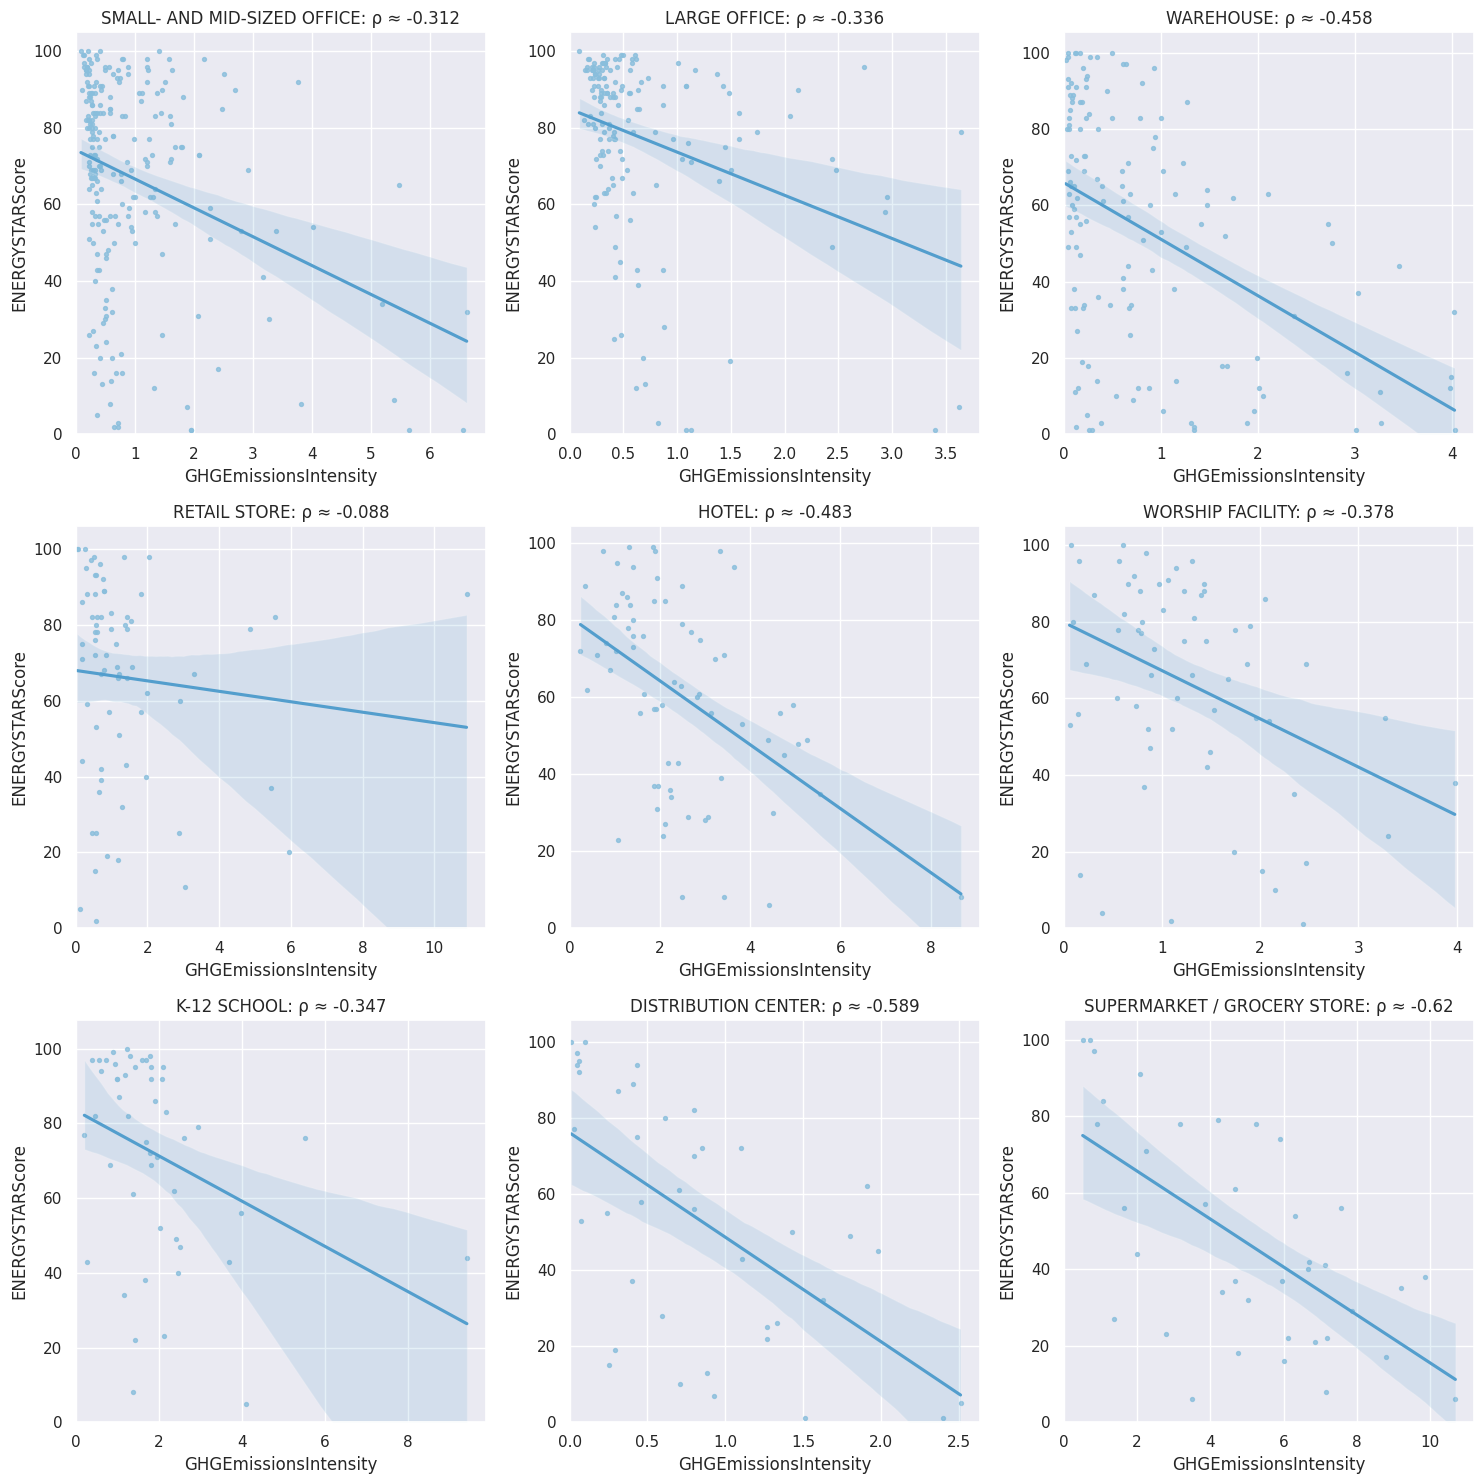

In [60]:
ghg = "GHGEmissionsIntensity"
build_ener_df_w_enstr = build_ener_df.loc[~build_ener_df["ENERGYSTARScore"].isna()]
top_prop_types = [
    x
    for x in build_ener_df_w_enstr["PrimaryPropertyType"]
    .value_counts()
    .index.values.tolist()
    if x not in ["Other", "Mixed Use Property"]
][0:9]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
sp_locs = [i for i in ax1] + [i for i in ax2] + [i for i in ax3]
loop_num = 0

sns.set_palette(sns.color_palette("Blues"))

theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for prop_type in top_prop_types:
    build_ener_prop_type_df = build_ener_df_w_enstr.loc[
        build_ener_df_w_enstr["PrimaryPropertyType"] == prop_type
    ]
    corr_coeff = (
        build_ener_prop_type_df[["GHGEmissionsIntensity", "ENERGYSTARScore"]]
        .corr()
        .to_numpy()[0][1]
    )
    rp = sns.regplot(
        data=build_ener_prop_type_df,
        x="GHGEmissionsIntensity",
        y="ENERGYSTARScore",
        ax=sp_locs[loop_num],
        line_kws={"color": theme_clrs[3]},
        scatter_kws={"color": theme_clrs[2], "s": 8},
    )

    rp.set(xlim=(0, None))
    rp.set(ylim=(0, None))
    sp_locs[loop_num].set_title(
        f"{prop_type.upper()}: \u03C1 \u2248 {round(corr_coeff, 3)}"
    )
    loop_num += 1

plt.tight_layout()
plt.show()


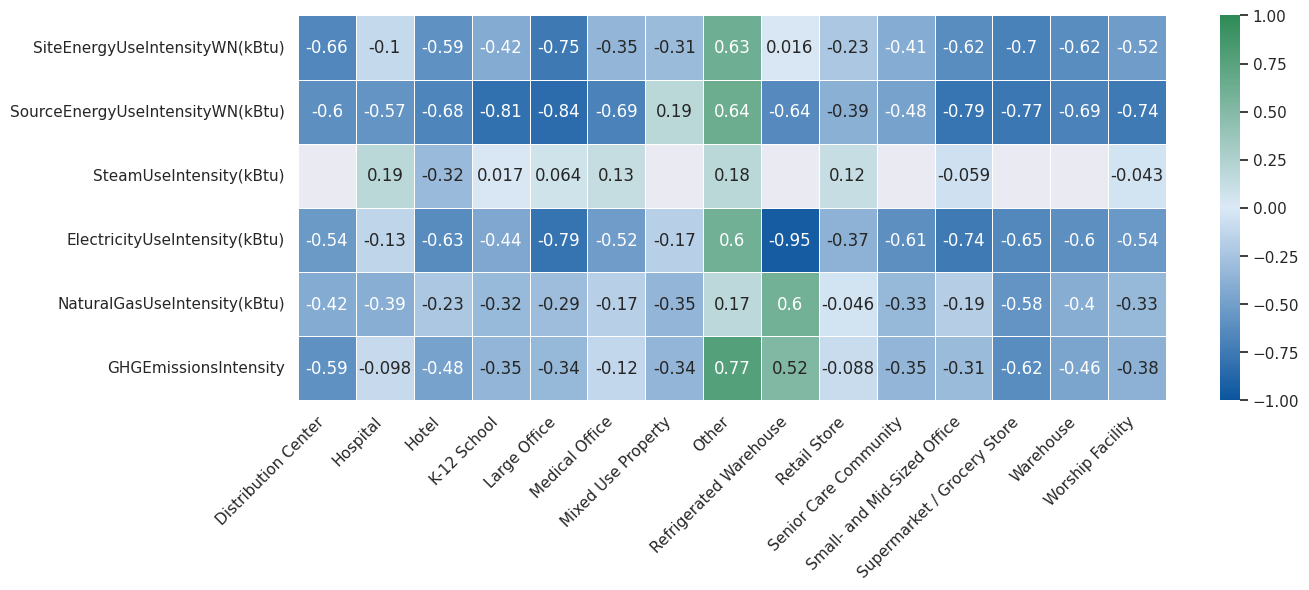

In [61]:
build_ener_df_w_intens_enstr = build_ener_df_w_intens.loc[
    ~build_ener_df_w_intens["ENERGYSTARScore"].isna()
]
prop_types = sorted(set(build_ener_df_w_intens_enstr["PrimaryPropertyType"].to_list()))
build_type_corr_df = pd.DataFrame(
    index=ener_feature_list, columns=prop_types, dtype="float64"
)

for prop_type in prop_types:
    prop_type_df = build_ener_df_w_intens_enstr.loc[
        build_ener_df_w_intens_enstr["PrimaryPropertyType"] == prop_type
    ]

    for index, row in build_type_corr_df.iterrows():
        build_type_corr_df.at[index, prop_type] = (
            prop_type_df[[index, "ENERGYSTARScore"]].corr().to_numpy()[0][1]
        )

f, ax = plt.subplots(figsize=(14, 5))
cmap = lsc.from_list("DbLbDb", [theme_clrs[5], theme_clrs[0], "seagreen"])

sns.heatmap(
    build_type_corr_df,
    vmin=-1.0,
    vmax=1.0,
    cmap=cmap,
    annot=True,
    linewidths=0.5,
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()


In [93]:
# shows need to exclude "Other" category when imputing EnergyStar

intensities = [
    "SiteEnergyUseIntensityWN",
    "SourceEnergyUseIntensityWN",
    "SteamUseIntensity",
    "ElectricityUseIntensity",
    "NaturalGasUseIntensity",
    "GHGEmissionsIntensity",
]
for prop_type in prop_types:
    prop_type_df = build_ener_df_w_intens_enstr.loc[
        build_ener_df_w_intens_enstr["PrimaryPropertyType"] == prop_type
    ]

    if len(set(prop_type_df["ENERGYSTARScore"].to_list())) == 1:
        continue
    
    prop_type_df.columns = prop_type_df.columns.str.replace("\(kBtu\)", "", regex=True)
    depend_vars = []

    for intens in intensities:
        # Avoids singular matrix
        if len(set(prop_type_df[intens].to_list())) > 3:
            depend_vars += [intens]

    manova_mdl = MANOVA.from_formula(" + ".join(depend_vars) + " ~ ENERGYSTARScore", data=prop_type_df)

    print(f"{prop_type}:\n{manova_mdl.mv_test()}")


Distribution Center:
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.2204 5.0000 34.0000 24.0582 0.0000
         Pillai's trace 0.7796 5.0000 34.0000 24.0582 0.0000
 Hotelling-Lawley trace 3.5380 5.0000 34.0000 24.0582 0.0000
    Roy's greatest root 3.5380 5.0000 34.0000 24.0582 0.0000
------------------------------------------------------------
                                                            
------------------------------------------------------------
    ENERGYSTARScore     Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.4306 5.0000 34.0000  8.9913 0.0000
         Pillai's trace 0.5694 5.0000 34.0000  8.9913 0.0000
 Hotelling-Lawley tra

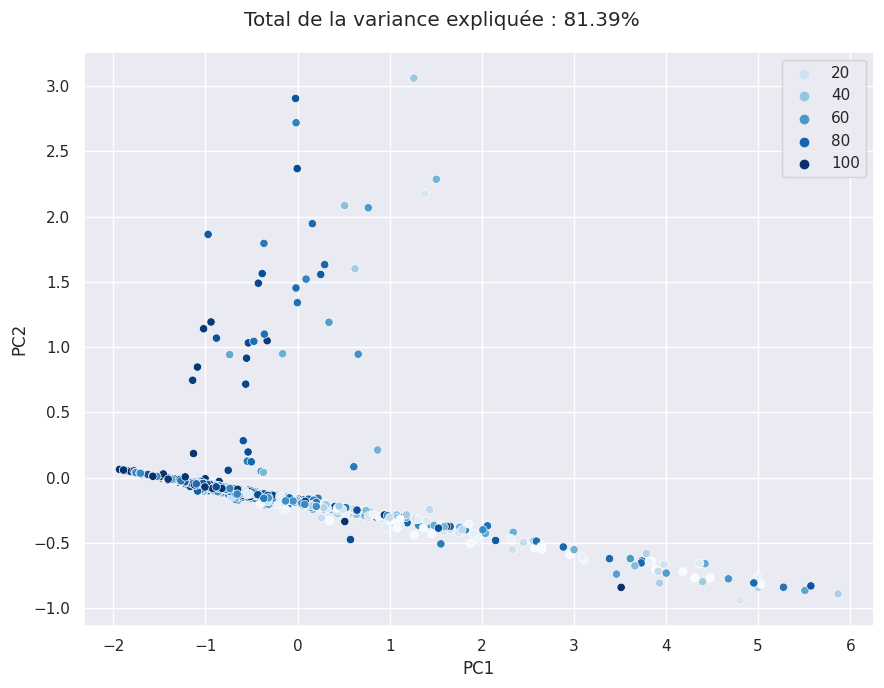

In [101]:
pca = PCA(n_components=2)
# feature_list = [
#     "YearBuilt",
#     "PropertyGFATotal",
#     "SiteEnergyUseWN(kBtu)",
#     "SourceEnergyUseWN(kBtu)",
#     "TotalGHGEmissions",
# ]
feature_list = [
    "SiteEnergyUseIntensityWN(kBtu)",
    "SourceEnergyUseIntensityWN(kBtu)",
    "SteamUseIntensity(kBtu)",
    "ElectricityUseIntensity(kBtu)",
    "NaturalGasUseIntensity(kBtu)",
    "GHGEmissionsIntensity",
]

# principal_components = pca.fit_transform(
#     StandardScaler().fit_transform(build_ener_df_w_enstr.loc[:, feature_list].values)
# )
build_ener_df_no_other = build_ener_df_w_intens_enstr.loc[
    ~(build_ener_df_w_intens_enstr["PrimaryPropertyType"] == "Other")
]
principal_components = pca.fit_transform(
    # StandardScaler().fit_transform(build_ener_df_w_intens_enstr.loc[:, feature_list].values)
    StandardScaler().fit_transform(build_ener_df_no_other.loc[:, feature_list].values)
)
exp_var_pct = round(sum(pca.explained_variance_ratio_) * 100, 2)
# print(exp_var_pct)
pc_df = pd.concat(
    [
        pd.DataFrame(data=principal_components, columns=["PC1", "PC2"]),
        pd.DataFrame(
            # data=build_ener_df_w_enstr["ENERGYSTARScore"].to_list(),
            # data=build_ener_df_w_intens_enstr["ENERGYSTARScore"].to_list(),
            data=build_ener_df_no_other["ENERGYSTARScore"].to_list(),
            columns=["ENERGYSTARScore"],
        ),
    ],
    axis=1,
)
zcore_to_filter = 3
z_scores = stats.zscore(pc_df[["PC1", "PC2"]])
abs_z_scores = np.abs(z_scores)
filt_entries = (abs_z_scores < zcore_to_filter).all(axis=1)
pc_df = pc_df[filt_entries]

sns.set_theme(style="darkgrid")

# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 7))

fig.suptitle(f"Total de la variance expliquée : {exp_var_pct}%")

sp1 = sns.scatterplot(
    data=pc_df,
    x="PC1",
    y="PC2",
    # ax=ax[0],
    ax=ax,
    hue="ENERGYSTARScore",
    # legend=False,
    palette="Blues",
)
# sp2 = sns.scatterplot(
#     data=pc_df, x="PC1", y="PC2", ax=ax[1], hue="ENERGYSTARScore", palette="Blues"
# )

# sp2.set(xscale="log", yscale="log")
# sp2.legend(bbox_to_anchor=(1, 1))
sp1.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [109]:
# iterative imputer for energy star scores
print(set(build_ener_df_w_intens_enstr.loc[build_ener_df_w_intens_enstr["PrimaryPropertyType"] == "Other"]["LargestPropertyUseType"].to_list()))

{'Courthouse', 'Financial Office', 'Bank Branch', 'Data Center'}


In [ ]:
#zipcode is a string, not numeric
float_to_int = [
    "ZipCode",
    "NumberofBuildings",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA",
    "ENERGYSTARScore",
]

build_ener_df[float_to_int] = build_ener_df[float_to_int].astype(int)
build_ener_df.info()


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
# save cleaned df